In [108]:
import sys, os
sys.path.insert(0, '/home/groups/rwr/alpv95/tracksml')
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/home/groups/rwr/alpv95/util/plot.mplstyle')
import torch
from util.methods import *
import pandas as pd
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
with fits.open('../example_data_train___nn_sim_spec__ensemble.fits', memmap=False) as hdu:
    heads = hdu[1].data

In [4]:
bar = torch.load('data/train/labels_full.pt')

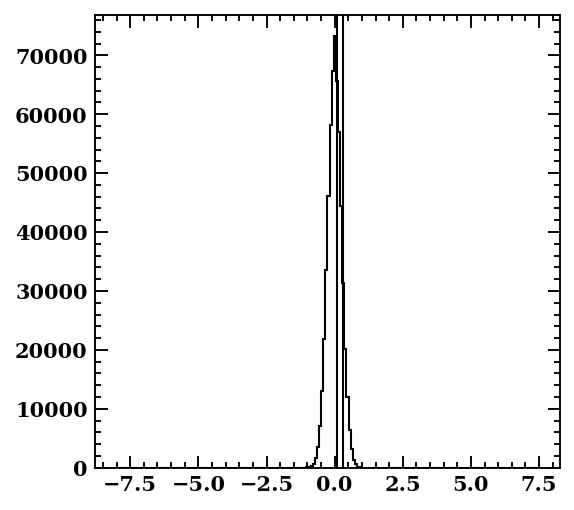

In [100]:
h = plt.hist(heads['XYZ_ABS'][:,0], bins=200, histtype='step')
plt.axvline(0.1)
plt.axvline(0.3)

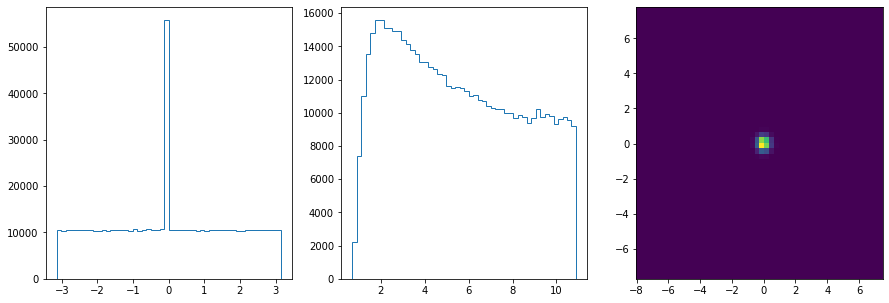

In [8]:
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
ax1, ax2, ax3 = ax

h = ax1.hist(heads['PHI'], bins=50, histtype='step')
h = ax2.hist(heads['ENERGY'], bins=50, histtype='step')
h = ax3.hist2d(heads['XYZ_ABS'][:,0],heads['XYZ_ABS'][:,1], bins=50)

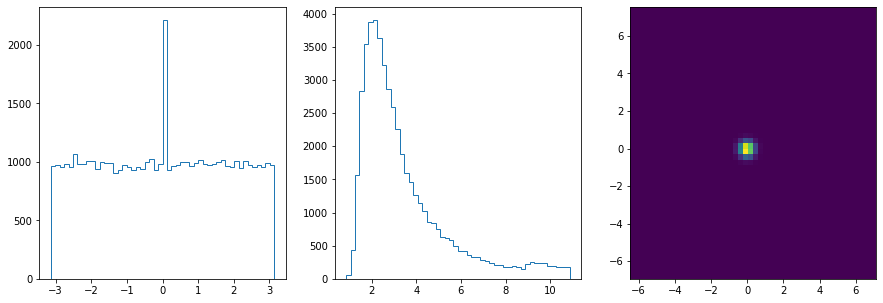

In [16]:
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
ax1, ax2, ax3 = ax

h = ax1.hist(mom_mc['PE_PHI'], bins=50, histtype='step')
h = ax2.hist(mom_mc['ENERGY'], bins=50, histtype='step')
h = ax3.hist2d(mom_mc['ABS_X'],mom_mc['ABS_Y'], bins=50)

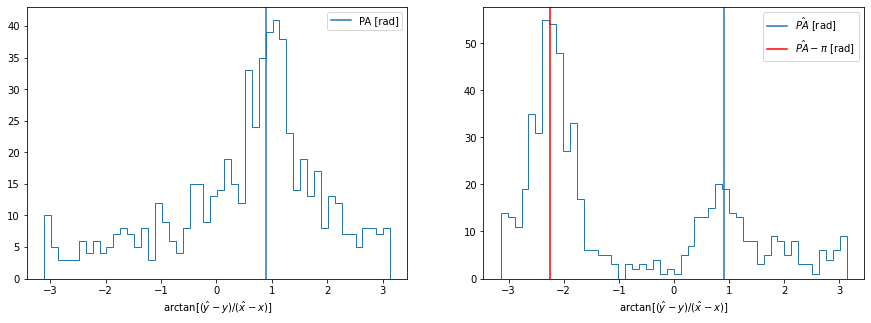

In [25]:
phi = 0.9
tol = 0.04

mask = (mom_mc['PE_PHI'] < phi + tol) * (mom_mc['PE_PHI'] > phi - tol) * (mom_mc['PE_PHI'] != 0.0) #* (mom_mc['ENERGY'])

abs_true = np.stack([mom_mc['ABS_X'],mom_mc['ABS_Y']],axis=1)
abs_mom = np.stack([mom_heads['DETX'],mom_heads['DETY']],axis=1)


MOM_ERR_VEC = -abs_true[mask] + abs_mom[mask]
MOM_ERR_PHI = np.arctan2(MOM_ERR_VEC[:,1],MOM_ERR_VEC[:,0]) 

mask = (mom_heads['DETPHI'] < phi + tol) * (mom_heads['DETPHI'] > phi - tol) * (mom_mc['PE_PHI'] != 0.0)#* (mom_mc['ENERGY'])

NN_ERR_VEC = -abs_true[mask] + abs_mom[mask]
NN_ERR_PHI = np.arctan2(NN_ERR_VEC[:,1],NN_ERR_VEC[:,0]) 

fig, ax = plt.subplots(figsize=(15,5),ncols=2)
ax1, ax2 = ax
h = ax1.hist(MOM_ERR_PHI,bins=50, histtype='step')
ax1.axvline(phi,label='PA [rad]')
h = ax2.hist(NN_ERR_PHI,bins=50, histtype='step')
ax2.axvline(phi, label=r'$\hat{PA}$ [rad]')
ax2.axvline(phi-np.pi, label=r'$\hat{PA} - \pi$ [rad]', color='r')
ax1.legend()
ax2.legend()
ax1.set_xlabel(r'$\arctan[(\hat y - y) / (\hat x - x)]$')
ax2.set_xlabel(r'$\arctan[(\hat y - y) / (\hat x - x)]$')
plt.savefig('pa_hist_mom.pdf',format='pdf',bbox_inches='tight')

(442,) (436,) (436,)


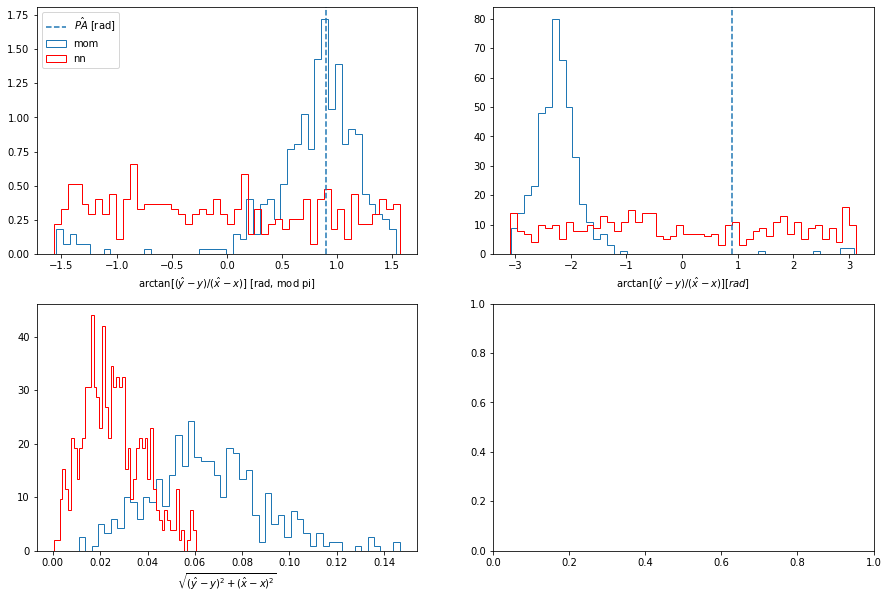

In [32]:
phi = 0.9
tol = 0.2
E = 1
etol = 0.1
mask = ( (heads['MOM_PHI'] < phi + tol) * (heads['MOM_PHI'] > phi - tol) * (heads['PHI'] != 0.0) 
        * (heads['ENERGY'] > E - etol) * (heads['ENERGY'] < E + etol))

MOM_ERR_VEC = -heads['XYZ_ABS'][:,:2][mask] + heads['XY_MOM_ABS'][mask]
MOM_ERR_PHI = np.arctan2(MOM_ERR_VEC[:,1],MOM_ERR_VEC[:,0]) 
MOM_ERR_R = np.sqrt(np.sum(MOM_ERR_VEC**2,axis=1))

mask = ((heads['NN_PHI'] < phi + tol) * (heads['NN_PHI'] > phi - tol) * (heads['PHI'] != 0.0)
        * (heads['ENERGY'] > E - etol) * (heads['ENERGY'] < E + etol))

NN_ERR_VEC = -heads['XYZ_ABS'][:,:2][mask] + heads['XY_NN_ABS'][mask]
NN_ERR_PHI = np.arctan2(NN_ERR_VEC[:,1],NN_ERR_VEC[:,0]) 
NN_ERR_R = np.sqrt(np.sum(NN_ERR_VEC**2,axis=1))

fig, ax = plt.subplots(figsize=(15,10),ncols=2, nrows=2)
ax1, ax2, ax3, ax4 = ax.flat
h = ax1.hist(pi2_pi2(MOM_ERR_PHI),bins=50, histtype='step',density=True, label='mom')
h = ax1.hist(pi2_pi2(NN_ERR_PHI),bins=50, histtype='step', color='r',density=True, label='nn')
h = ax3.hist(MOM_ERR_R[MOM_ERR_R < 0.5],bins=50, histtype='step',density=True)
h = ax3.hist(NN_ERR_R[NN_ERR_R < 0.5],bins=50, histtype='step', color='r',density=True)
print(MOM_ERR_R[MOM_ERR_R < 0.5].shape, NN_ERR_R[NN_ERR_R < 0.5].shape, NN_ERR_R.shape )
ax1.axvline(phi,label=r'$\hat{PA}$ [rad]', ls='--')
ax2.axvline(phi,label=r'$\hat{PA}$ [rad]', ls='--')
ax1.legend(loc=2)

h = ax2.hist(MOM_ERR_PHI,bins=50, histtype='step')
h = ax2.hist(NN_ERR_PHI,bins=50, histtype='step', color='r')

ax1.set_xlabel(r'$\arctan[(\hat y - y) / (\hat x - x)]$ [rad, mod pi]')
ax2.set_xlabel(r'$\arctan[(\hat y - y) / (\hat x - x)] [rad]$')
ax3.set_xlabel(r'$\sqrt{(\hat y - y)^2 + (\hat x - x)^2}$')
plt.savefig('pa_hist.pdf',format='pdf',bbox_inches='tight')

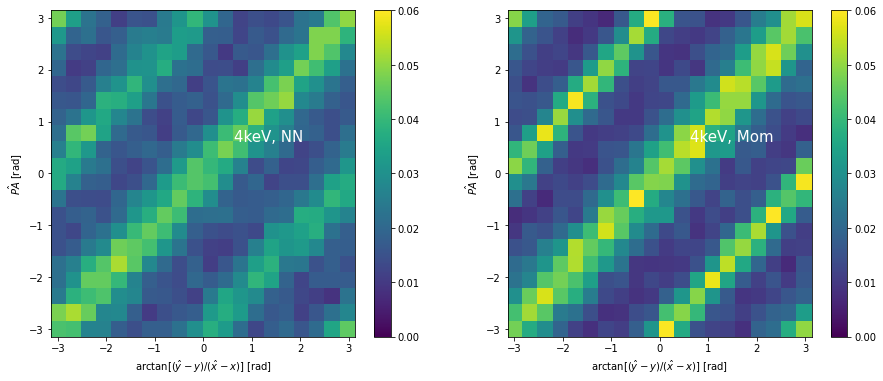

In [121]:
E = 2
tol = 0.2
mask = (heads['ENERGY'] < E + tol) * (heads['ENERGY'] > E - tol) * (heads['PHI'] != 0.0)

PHI = heads['NN_PHI'][mask]
NN_ERR_VEC = -heads['XYZ_ABS'][mask][:,:2] + heads['XY_NN_ABS'][mask]
NN_ERR_PHI = np.arctan2(NN_ERR_VEC[:,1],NN_ERR_VEC[:,0]) 

MOM_PHI = heads['MOM_PHI'][mask]
MOM_ERR_VEC = -heads['XYZ_ABS'][mask][:,:2] + heads['XY_MOM_ABS'][mask]
MOM_ERR_PHI = np.arctan2(MOM_ERR_VEC[:,1], MOM_ERR_VEC[:,0]) 

fig, ax = plt.subplots(figsize=(15,6),ncols=2)
ax1, ax2 = ax

import matplotlib as mpl
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=0.06)

h = ax1.hist2d(NN_ERR_PHI, PHI, bins=20, cmap=cmap, norm=norm, density=True)
ax1.annotate(f'{E}keV, NN', xy=(0.6,0.6), xycoords='axes fraction', fontsize=15, color='white')
plt.colorbar(h[3],ax=ax1)

h = ax2.hist2d(MOM_ERR_PHI, MOM_PHI, bins=20, cmap=cmap, norm=norm, density=True)
ax2.annotate(f'{E}keV, Mom', xy=(0.6,0.6), xycoords='axes fraction', fontsize=15, color='white')
plt.colorbar(h[3],ax=ax2)

ax1.set_xlabel(r'$\arctan[(\hat y - y) / (\hat x - x)]$ [rad]')
ax2.set_xlabel(r'$\arctan[(\hat y - y) / (\hat x - x)]$ [rad]')

ax1.set_ylabel(r'$\hat{PA}$ [rad]')
ax2.set_ylabel(r'$\hat{PA}$ [rad]')

plt.savefig(f'{E}kev_hist.pdf',format='pdf',bbox_inches='tight')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


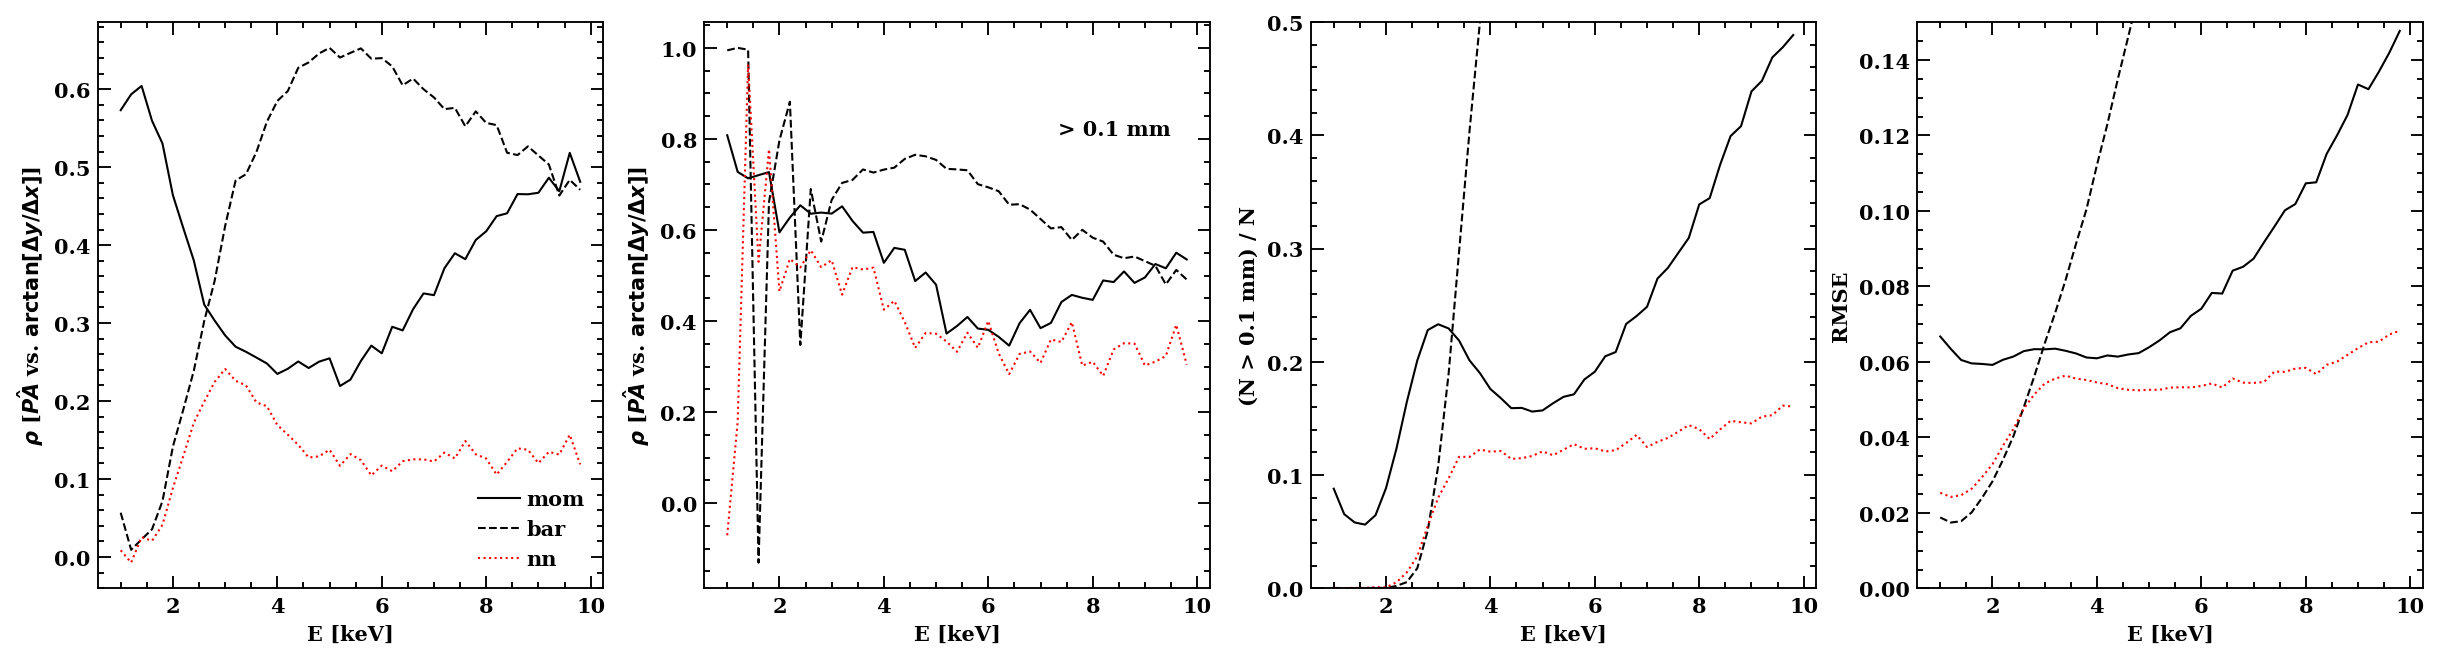

In [35]:
tol = 0.1
step = 2 * tol
dist = 0.1
Es = np.arange(1,10,step)

nn_corr = []
mom_corr = []
bar_corr = []

nn_corr_thresh = []
mom_corr_thresh = []
bar_corr_thresh = []

nn_thresh = []
mom_thresh = []
bar_thresh = []

nn_mse = []
mom_mse = []
bar_mse = []

for E in Es:
    mask = (heads['ENERGY'] < E + tol) * (heads['ENERGY'] > E - tol) * (heads['PHI'] != 0.0)
    
    PHI = heads['NN_PHI'][mask]
    NN_ERR_VEC = -heads['XYZ_ABS'][mask][:,:2] + heads['XY_NN_ABS'][mask]
    NN_ERR_PHI = np.arctan2(NN_ERR_VEC[:,1],NN_ERR_VEC[:,0]) 
    NN_ERR_R = np.sqrt(np.sum(NN_ERR_VEC**2,axis=1))
    
    nn_mask_thresh = NN_ERR_R > dist
    nn_thresh.append(len(PHI[nn_mask_thresh])/len(PHI))
    nn_mse.append(np.mean(NN_ERR_R))

    MOM_PHI = heads['MOM_PHI'][mask]
    MOM_ERR_VEC = -heads['XYZ_ABS'][mask][:,:2] + heads['XY_MOM_ABS'][mask]
    MOM_ERR_PHI = np.arctan2(MOM_ERR_VEC[:,1], MOM_ERR_VEC[:,0]) 
    MOM_ERR_R = np.sqrt(np.sum(MOM_ERR_VEC**2,axis=1))
    
    mom_mask_thresh = MOM_ERR_R > dist
    mom_thresh.append(len(MOM_PHI[mom_mask_thresh])/len(MOM_PHI))
    mom_mse.append(np.mean(MOM_ERR_R))
    
    BAR_PHI = heads['MOM_PHI'][mask]
    BAR_ERR_VEC = -heads['XYZ_ABS'][mask][:,:2] + bar['xy_bar'].numpy()[mask]
    BAR_ERR_PHI = np.arctan2(BAR_ERR_VEC[:,1], BAR_ERR_VEC[:,0]) 
    BAR_ERR_R = np.sqrt(np.sum(BAR_ERR_VEC**2,axis=1))
    
    bar_mask_thresh = BAR_ERR_R > dist
    bar_thresh.append(len(BAR_PHI[bar_mask_thresh])/len(BAR_PHI))
    bar_mse.append(np.mean(BAR_ERR_R))

    nn_corr.append(np.corrcoef(np.stack([pi2_pi2(PHI),pi2_pi2(NN_ERR_PHI)]))[0,1])
    mom_corr.append(np.corrcoef(np.stack([pi2_pi2(MOM_PHI),pi2_pi2(MOM_ERR_PHI)]))[0,1])
    bar_corr.append(np.corrcoef(np.stack([pi2_pi2(BAR_PHI),pi2_pi2(BAR_ERR_PHI)]))[0,1])
    nn_corr_thresh.append(np.corrcoef(np.stack([pi2_pi2(PHI[nn_mask_thresh]),
                                                pi2_pi2(NN_ERR_PHI[nn_mask_thresh])]))[0,1])
    mom_corr_thresh.append(np.corrcoef(np.stack([pi2_pi2(MOM_PHI[mom_mask_thresh]),
                                                 pi2_pi2(MOM_ERR_PHI[mom_mask_thresh])]))[0,1])
    bar_corr_thresh.append(np.corrcoef(np.stack([pi2_pi2(BAR_PHI[bar_mask_thresh]),
                                                 pi2_pi2(BAR_ERR_PHI[bar_mask_thresh])]))[0,1])
    
    
fig, ax = plt.subplots(figsize=(20,5), ncols=4)
ax1, ax2, ax3, ax4 = ax.flat

ax1.plot(Es, mom_corr, label='mom')
ax1.plot(Es, bar_corr, label='bar')
ax1.plot(Es, nn_corr, color='r', label='nn')
ax1.set_xlabel('E [keV]')
ax1.set_ylabel(r'$\rho$ [$\hat{PA}$ vs. $\arctan[\Delta y / \Delta x]$]')
ax1.legend()

ax2.plot(Es, mom_corr_thresh, label='mom')
ax2.plot(Es, bar_corr_thresh, label='bar')
ax2.plot(Es, nn_corr_thresh, color='r', label='nn')
ax2.set_xlabel('E [keV]')
ax2.set_ylabel(r'$\rho$ [$\hat{PA}$ vs. $\arctan[\Delta y / \Delta x]$]')
ax2.annotate(f'> {dist} mm', xy=(0.7,0.8), xycoords='axes fraction')

ax3.plot(Es, mom_thresh, label='mom')
ax3.plot(Es, bar_thresh, label='bar')
ax3.plot(Es, nn_thresh, color='r', label='nn')
ax3.set_xlabel('E [keV]')
ax3.set_ylabel(f'(N > {dist} mm) / N')
ax3.set_ylim(0.0, 0.5)

ax4.plot(Es, mom_mse, label='mom')
ax4.plot(Es, bar_mse, label='bar')
ax4.plot(Es, nn_mse, color='r', label='nn')
ax4.set_xlabel('E [keV]')
ax4.set_ylabel('RMSE')
ax4.set_ylim(0.0, 0.15)

plt.savefig(f'correlation_full.pdf',format='pdf',bbox_inches='tight')

## Simulating a point source

Calculate polarization for both moments and NNs for a quadrant or pizza slice of the Gaussian point source, with full error distribution. NN should find lower polarization within errors.

In [40]:
from IPython.display import display, Latex

In [52]:
mask = (heads['ENERGY'] < 8) * (heads['ENERGY'] > 2) * (heads['PHI'] != 0.0)
switch = 3.2

mu, phi0, Neff, mu_err, phi_err = weighted_stokes(heads['NN_PHI'][mask], error=True)
display(Latex(f"$\mu$: {mu:.4f} $\pm$ {mu_err:.4f}, $\phi_0$: {phi0:.4f} $\pm$ {phi_err:.4f}"))

mu, phi0, Neff, mu_err, phi_err = weighted_stokes(heads['MOM_PHI'][mask], error=True) 
display(Latex(f"$\mu$: {mu:.4f} $\pm$ {mu_err:.4f}, $\phi_0$: {phi0:.4f} $\pm$ {phi_err:.4f}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [103]:
mask = (heads['ENERGY'] < 8) * (heads['ENERGY'] > 2) * (heads['PHI'] != 0.0)
switch = 3.2
r1 = 0.15
r2 = 0.3
phi1 = -4
phi2 = -2

mom_abs = np.where(np.tile(heads['ENERGY'],(2,1)).T > switch, 
                   heads['XY_MOM_ABS'], 
                   bar['xy_bar'].numpy())
results = [[] for _ in range(4)]

for r1,r2,phi1,phi2 in [(0,0.15,-4,4),
                        (0.15,0.4,-np.pi,-np.pi/2),
                       (0.15,0.4,-np.pi/2,0),
                       (0.15,0.4,0,np.pi/2),
                       (0.15,0.4,np.pi/2,np.pi)]: 
  
  r = np.sum(mom_abs**2,axis=1)
  phi = np.arctan2(mom_abs[:,1], mom_abs[:,0])
  mask_slice = (r > r1) * (r < r2) * (phi > phi1) * (phi < phi2)

  mu, phi0, _, mu_err, phi_err = weighted_stokes(heads['MOM_PHI'][mask*mask_slice], error=True)
  results[0].append(f"{mu:.4f} $\pm$ {mu_err:.4f}")

  r = np.sum(heads['XY_NN_ABS']**2,axis=1)
  phi = np.arctan2(heads['XY_NN_ABS'][:,1], heads['XY_NN_ABS'][:,0])
  mask_slice = (r > r1) * (r < r2) * (phi > phi1) * (phi < phi2)

  mu, phi0, Neff, mu_err, phi_err = weighted_stokes(heads['NN_PHI'][mask*mask_slice], error=True)
  # display(Latex(f"$\mu$: {mu:.4f} $\pm$ {mu_err:.4f}, $\phi_0$: {phi0:.4f} $\pm$ {phi_err:.4f}"))
  results[1].append(f"{mu:.4f} $\pm$ {mu_err:.4f}")

  r = np.sum(heads['XYZ_ABS'][:,:2]**2,axis=1)
  phi = np.arctan2(heads['XYZ_ABS'][:,1], heads['XYZ_ABS'][:,0])
  mask_slice = (r > r1) * (r < r2) * (phi > phi1) * (phi < phi2)

  mu, phi0, Neff, mu_err, phi_err = weighted_stokes(heads['MOM_PHI'][mask*mask_slice], error=True)
  # display(Latex(f"$\mu$: {mu:.4f} $\pm$ {mu_err:.4f}, $\phi_0$: {phi0:.4f} $\pm$ {phi_err:.4f}"))
  results[2].append(f"{mu:.4f} $\pm$ {mu_err:.4f}")
  mu, phi0, Neff, mu_err, phi_err = weighted_stokes(heads['NN_PHI'][mask*mask_slice], error=True)
  # display(Latex(f"$\mu$: {mu:.4f} $\pm$ {mu_err:.4f}, $\phi_0$: {phi0:.4f} $\pm$ {phi_err:.4f}"))
  results[3].append(f"{mu:.4f} $\pm$ {mu_err:.4f}")

In [111]:
pd.DataFrame(results, index=['mom','NN','mom_true','NN_true'], columns=[f"r < 0.15", 
                               f"0.15 < r < 0.4, -pi < phi < -pi/2", 
                               f"0.15 < r < 0.4, -pi/2 < phi < 0", 
                               f"0.15 < r < 0.4, 0 < phi < pi/2", 
                               f"0.15 < r < 0.4, pi/2 < phi < pi"])

,r < 0.15,"0.15 < r < 0.4, -pi < phi < -pi/2","0.15 < r < 0.4, -pi/2 < phi < 0","0.15 < r < 0.4, 0 < phi < pi/2","0.15 < r < 0.4, pi/2 < phi < pi"
mom,0.0029 $\pm$ 0.0029,0.0336 $\pm$ 0.0090,0.0670 $\pm$ 0.0091,0.0586 $\pm$ 0.0090,0.0465 $\pm$ 0.0090
NN,0.0025 $\pm$ 0.0029,0.0090 $\pm$ 0.0091,0.0379 $\pm$ 0.0092,0.0333 $\pm$ 0.0091,0.0227 $\pm$ 0.0091
mom_true,0.0022 $\pm$ 0.0028,0.0200 $\pm$ 0.0093,0.0189 $\pm$ 0.0093,0.0148 $\pm$ 0.0092,0.0053 $\pm$ 0.0093
NN_true,0.0028 $\pm$ 0.0028,0.0197 $\pm$ 0.0093,0.0250 $\pm$ 0.0093,0.0138 $\pm$ 0.0092,0.0099 $\pm$ 0.0093
